In [1]:
import numpy as np
import matplotlib.pyplot as plt

### Introduction to Visualization:
Density Estimation and Data Exploration
========

##### Version 0.3

***
By AA Miller (Northwestern/CIERA)  
08 May 2025


**Notebook summary and goals**

In this notebook you will learn about kernel density estimation (KDE) as an alternative to histograms, while building intution for how KDE works. There is also an introduction to [`seaborn`](https://seaborn.pydata.org/), a python package that is particularly well suited to exploring large dimension data sets. 

## Problem 1) Density Estimation

We are in an era where data and large statistical samples are abundant, starting from 2MASS and SDSS to the Rubin Observatory. However, with this data explosion, we face the challenge of not knowing the underlying probability density function (PDF) of the observed random variables.

Hence - density estimation: an attempt to recover the unknown PDF from observations. In some cases theory can guide us to a parametric form for the PDF, but more often than not such guidance is not available. 

There is a common, simple, and very familiar tool for density estimation: histograms. 

But there is also a problem:

HISTOGRAMS LIE!

We will "prove" this via example. Using the Linnerud data set, which tested 20 middle aged men by measuring the number of chinups, situps, and jumps they could do in order to compare these numbers to their weight, pulse, and waist size. Execute the cell below to load the data (just chinups for now).

In [2]:
from sklearn.datasets import load_linnerud

linnerud = load_linnerud()
chinups = linnerud.data[:,0]

**Problem 1a** 

Plot the histogram for the number of chinups using the default settings in pyplot.

In [3]:
import matplotlib.pyplot as plt

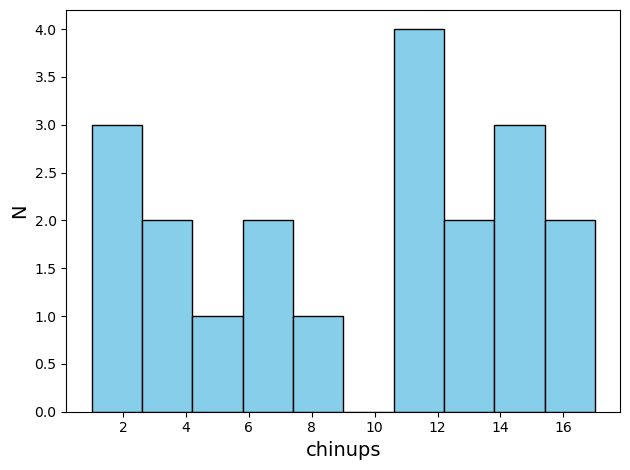

In [4]:
fig, ax = plt.subplots()
ax.hist(chinups, bins=10, color='skyblue', edgecolor='black')
ax.set_xlabel('chinups', fontsize=14)
ax.set_ylabel('N', fontsize=14)
fig.tight_layout()
plt.show()

Something is wrong here - the histogram suggests that there is a 0% probability that middle aged men can do 10 chinups. This is intuitively incorrect - what if we adjust the histogram bins?


**Problem 1b** 

Make 2 new histograms: (i) one with 5 bins (`bins = 5`), and (ii) one with the bars centered on the left bin edges (`align = "left"`).

*Hint - if overplotting the results, you may find it helpful to use the `histtype = "step"` option*

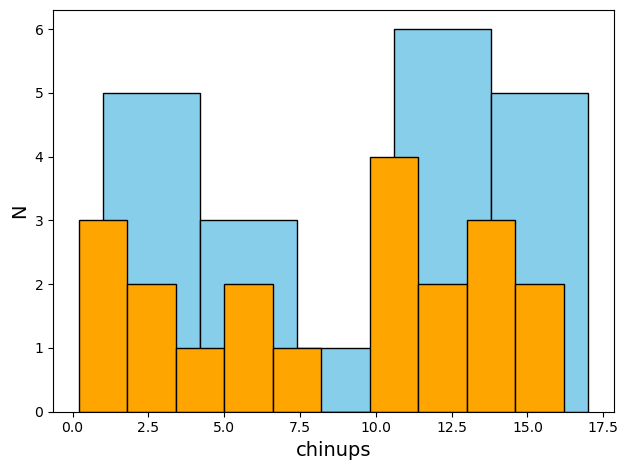

In [5]:
fig, ax = plt.subplots()
ax.hist(chinups, bins=5, color='skyblue', edgecolor='black', label="bins=5")
ax.hist(chinups, bins=10, color='orange', edgecolor='black', label="bins=10", align='left')
ax.set_xlabel('chinups', fontsize=14)
ax.set_ylabel('N', fontsize=14)
fig.tight_layout()

These small changes significantly change the estimator for the PDF. Fewer bins avoid probability = 0, while shifting the bin centers reduces the probability to zero at 9 chinups. 

What if we instead allow the bin width to vary and require the same number of points in each bin? You can determine the bin edges for bins with 5 sources using the following command:

`bins = np.append(np.sort(chinups)[::5], 
                  np.max(chinups))`

**Problem 1c** 

Plot a histogram with variable width bins, each with the same number of points.

*Hint - setting `density = True` will normalize the bin heights so that the PDF integrates to 1.*

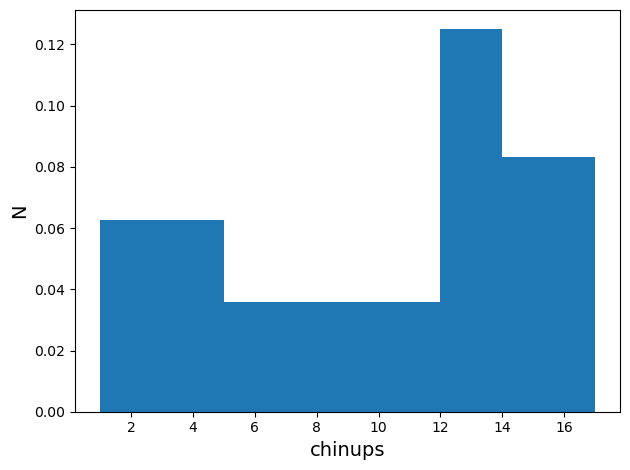

In [6]:
bins = np.append(np.sort(chinups)[::5], np.max(chinups))
fig, ax = plt.subplots()
ax.hist( chinups, bins=bins, density=True)
ax.set_xlabel('chinups', fontsize=14)
ax.set_ylabel('N', fontsize=14)
fig.tight_layout()

*Ending the lie* 

Histograms lie, tell the "truth": show all the data so the effects of bin choices are clear
.  Adding a rug plot, which shows a vertical tick for each source, provides additional clarity.

(If your data set is large, i.e., if you are a survey astronomer in 2025, rug plots are cumbersome and likely to be ineffective...)

**Problem 1d** 

Execute the cell below to see an example of a rug plot. 

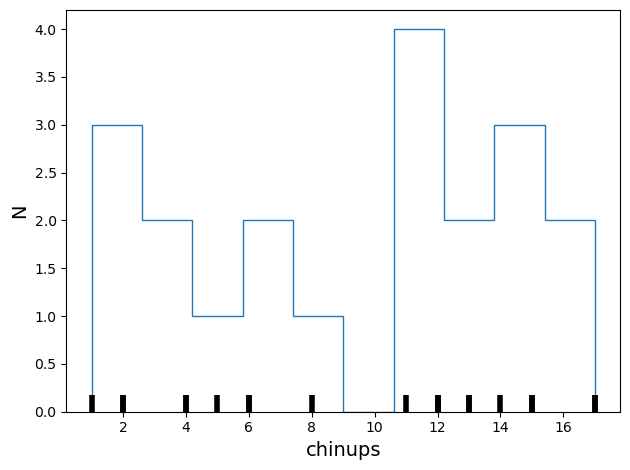

In [7]:
fig, ax = plt.subplots()
ax.hist(chinups, histtype = 'step')

# this is the code for the rug plot
ax.plot(chinups, np.zeros_like(chinups), '|', color='k', ms = 25, mew = 4)
ax.set_xlabel('chinups', fontsize=14)
ax.set_ylabel('N', fontsize=14)
fig.tight_layout()

Rug plots are also imperfect. What if a measurement is repeated? A (slightly) better solution is to vary the transparency of the rug "whiskers" using `alpha = 0.3`. But this too is far from perfect. 

To recap, histograms are not ideal for density estimation: 

* They introduce discontinuities that are not present in the data


* They are strongly sensitive to user choices ($N_\mathrm{bins}$, bin centering, bin grouping), without any mathematical guidance to what these choices should be


* They are difficult to visualize in higher dimensions

Histograms are useful for generating a quick representation of univariate data, but they should never be used for analysis. 

Never, ever, ever, EVER fit functions to histograms given how greatly the number of bins and bin centering affects the output histogram.

There must be a better option!

(*sound of slowly building classical music*) Enter: [Kernel Density Estimation](https://en.wikipedia.org/wiki/Kernel_density_estimation) (KDE). 

KDE is a nonparametric density estimation method that uses a normalized kernel function convolved with discrete data to estimate the underlying PDF. The kernel must integrate to 1 over the interval $-\infty$ to $\infty$ and be symmetric. Popular kernels include Gaussian and Epanechnikov, the latter minimizing mean square error.


KDE is not completely free of the problems above (both a kernel and its width need to be selected), but it does manage to correct a number of the ills. We will now demonstrate this via a few examples using the `scikit-learn` implementation of KDE: [`KernelDensity`](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KernelDensity.html#sklearn.neighbors.KernelDensity). 

*Note* – Jake VanderPlas has put together [an excellent description of different python KDE implementations](https://jakevdp.github.io/blog/2013/12/01/kernel-density-estimation/).

To demonstrate the basic idea behind KDE, represent each point in the dataset as a block (i.e., the tophat kernel). We can estimate the KDE using the following code:

    from sklearn.neighbors import KernelDensity
    def kde_sklearn(data, grid, bandwidth = 1.0, **kwargs):
        kde_skl = KernelDensity(bandwidth = bandwidth, **kwargs)
        kde_skl.fit(data[:, np.newaxis])
        log_pdf = kde_skl.score_samples(grid[:, np.newaxis]) # sklearn returns log(density)
        
        return np.exp(log_pdf)
        
The two main options to set are the bandwidth and the kernel. 

In [8]:
# execute this cell
from sklearn.neighbors import KernelDensity
def kde_sklearn(data, grid, bandwidth = 1.0, **kwargs):
    kde_skl = KernelDensity(bandwidth = bandwidth, **kwargs)
    kde_skl.fit(data[:, np.newaxis])
    log_pdf = kde_skl.score_samples(grid[:, np.newaxis]) # sklearn returns log(density)

    return np.exp(log_pdf)

**Problem 1e** 

Plot the KDE of the PDF for the number of chinups middle aged men can do using a bandwidth of 0.1 and a tophat kernel.

*Hint - as a general rule, the grid should be smaller than the bandwidth when plotting the PDF (i.e., >200 points in this case)*

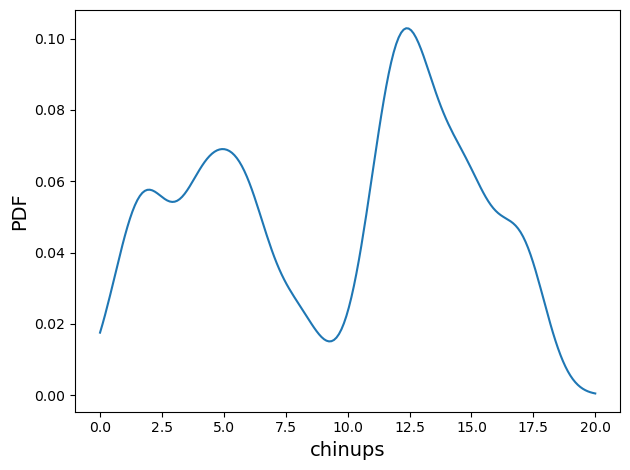

In [9]:
grid = np.linspace(0, 20, 200)
PDFtophat = kde_sklearn( chinups, grid, bandwidth=1)

fig, ax = plt.subplots()
ax.plot(grid, PDFtophat)
ax.set_xlabel('chinups', fontsize=14)
ax.set_ylabel('PDF', fontsize=14)
fig.tight_layout()
plt.show()

In this representation, each "block" has a height of 0.25. The bandwidth is too narrow to provide any overlap between the blocks. This choice of kernel and bandwidth produces an estimate that is essentially a histogram with a large number of bins. It gives no sense of continuity for the distribution. Now, we examine the difference (relative to histograms) upon changing the the width (i.e. kernel) of the blocks. 

**Problem 1f** 

Plot the KDE of the PDF for the number of chinups middle aged men can do using bandwidths of 1 and 5 and a tophat kernel. 

How do the results differ from the histogram plots above? 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


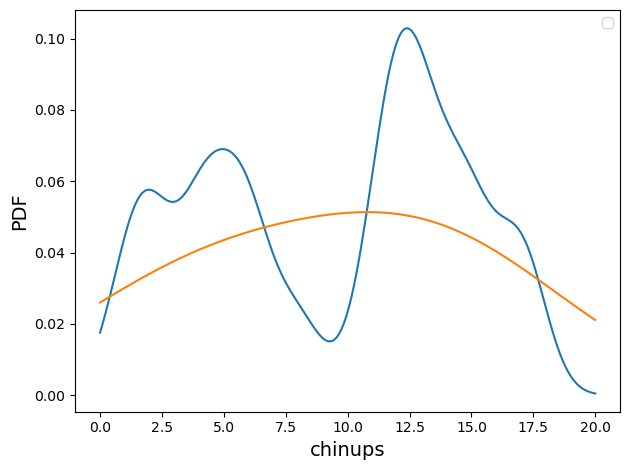

In [10]:
PDFtophat1 = kde_sklearn( chinups, grid, bandwidth=1)
PDFtophat5 = kde_sklearn( chinups, grid, bandwidth=5)

fig, ax = plt.subplots()
ax.plot(grid, PDFtophat1)
ax.plot(grid, PDFtophat5)
ax.set_xlabel('chinups', fontsize=14)
ax.set_ylabel('PDF', fontsize=14)
fig.tight_layout()
ax.legend()

The KDE with bandwidth 1 is more sensitive to valleys and peaks, while bandwidth 5 is smoother

Blocks are not an ideal representation for continuous data. What about a Gaussian?

**Problem 1g** Plot the KDE of the PDF for the number of chinups middle aged men can do using a gaussian and Epanechnikov kernel. How do the results differ from the histogram plots above? 

*Hint - you will need to select the bandwidth. The examples above should provide insight into the useful range for bandwidth selection. You may need to adjust the values to get an answer you "like."*

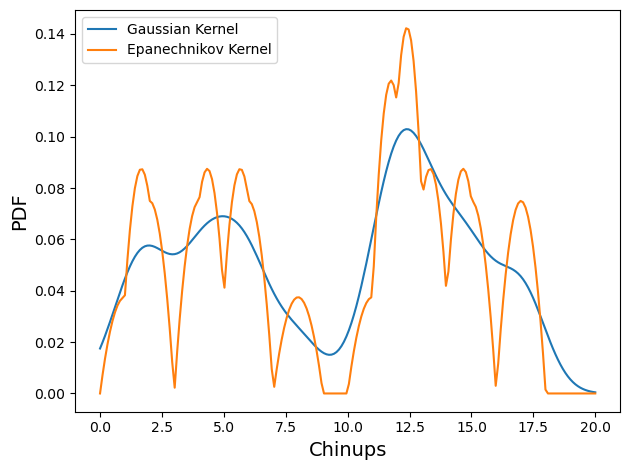

In [11]:
grid = grid.reshape(-1, 1)

kde_gaussian = KernelDensity(kernel='gaussian', bandwidth=1).fit(chinups[:, np.newaxis])
PDFgaussian = np.exp(kde_gaussian.score_samples(grid))

kde_epanechnikov = KernelDensity(kernel='epanechnikov', bandwidth=1).fit(chinups[:, np.newaxis])
PDFepanechnikov = np.exp(kde_epanechnikov.score_samples(grid))

fig, ax = plt.subplots()
ax.plot(grid, PDFgaussian, label='Gaussian Kernel')
ax.plot(grid, PDFepanechnikov, label='Epanechnikov Kernel')
ax.legend(loc=2)
ax.set_xlabel('Chinups', fontsize=14)
ax.set_ylabel('PDF', fontsize=14)
fig.tight_layout()

plt.show()

So, what is the *optimal* choice of bandwidth and kernel? 

This varies by problem. Generally, bandwidth is more crucial than the kernel choice. For nearly Gaussian PDFs, Silverman's rule of thumb can be used:

$$h = 1.059 \sigma n^{-1/5}$$

where $h$ is the bandwidth, $\sigma$ is the standard deviation, and $n$ is the sample size. However, this rule may be inaccurate for bimodal or complex distributions. Cross-validation is the most general method for estimating bandwidth, which will be covered in the Machine Learning session.


*What about multidimensional PDFs?* It is possible using many of the Python implementations of KDE to estimate multidimensional PDFs, though it is very very important to beware the curse of dimensionality in these circumstances.

## Problem 2) Data Exploration

**Disclaimer** – there is no single best method for data exploration. 

As an example we will start with a basic line plot - and examine tools beyond `matplotlib`.

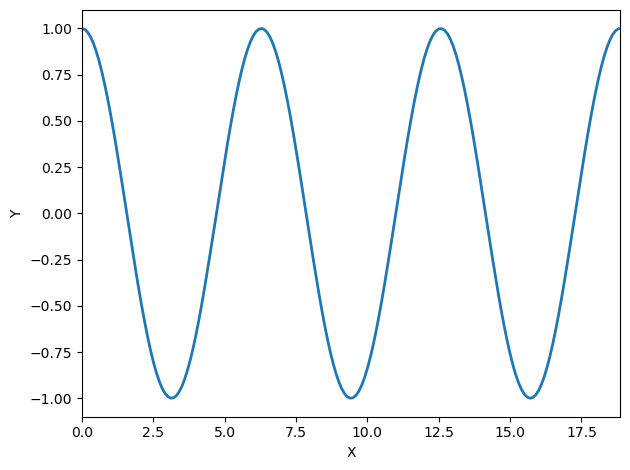

In [12]:
x = np.arange(0, 6*np.pi, 0.1)
y = np.cos(x)

fig, ax=plt.subplots()
ax.plot(x,y, lw = 2)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_xlim(0, 6*np.pi)
fig.tight_layout()

### Seaborn

[`Seaborn`](https://stanford.edu/~mwaskom/software/seaborn/index.html) is a plotting package that enables many useful features for exploration. 

Built-in tools in `seaborn` can reproduce everything from **Problem 1** in a single call.

Recreate the above `matplotlib` plot using `Seaborn`. 

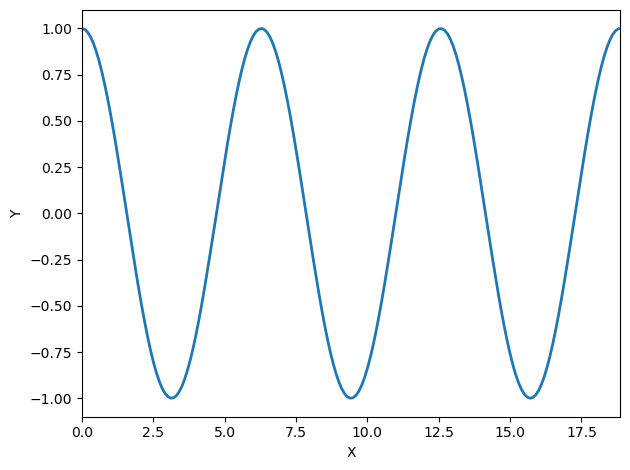

In [13]:
import seaborn as sns

fig, ax = plt.subplots()

ax.plot(x,y, lw = 2)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_xlim(0, 6*np.pi)
fig.tight_layout()

These plots look identical, but it is possible to change the style with `seaborn`. 

`seaborn` has 5 style presets: `darkgrid`, `whitegrid`, `dark`, `white`, and `ticks`. You can change the preset using the following: 

    sns.set_style("whitegrid")
 
which will change the output for all subsequent plots. Note - if you want to change the style for only a single plot, that can be accomplished with the following: 

    with sns.axes_style("dark"):

with all ploting commands inside the `with` statement. 

**Problem 2a** 

Re-plot the sine curve using each `seaborn` preset to see which you like best - then adopt this for the remainder of the notebook. 

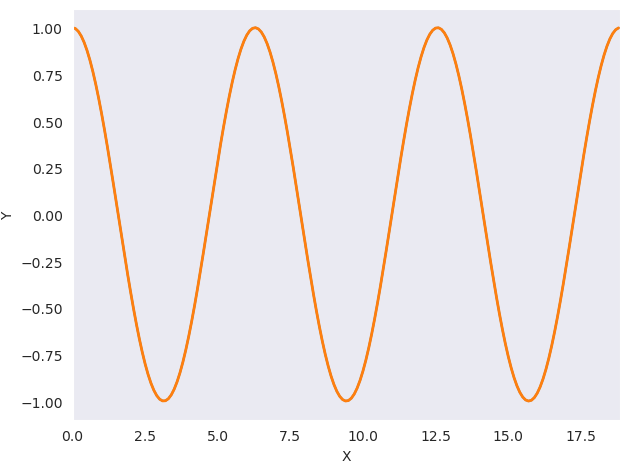

In [14]:
with sns.axes_style("dark"): 
    fig, ax = plt.subplots()
    sns.lineplot(x=x, y=y)
    ax.plot(x, y, lw=2)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_xlim(0, 6*np.pi)
    fig.tight_layout()

The `seaborn` devs have thought a lot about color palettes.

A poor choice of colors can easily mask interesting patterns or suggest structure that is not real. To learn more about what is available, see the [`seaborn` color tutorial](http://stanford.edu/~mwaskom/software/seaborn/tutorial/color_palettes.html). 

Here we load the default:

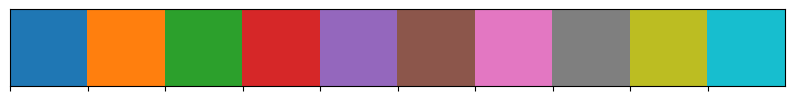

In [15]:
# default color palette

current_palette = sns.color_palette()
sns.palplot(current_palette)

which we will now change to `colorblind`, which is clearer to those that are colorblind.

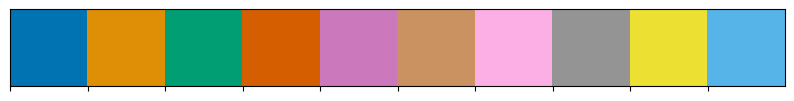

In [16]:
# set palette to colorblind
sns.set_palette("colorblind")

current_palette = sns.color_palette()
sns.palplot(current_palette)

Beyond the basics (we barely scratched the surface), `seaborn` is also powerful for higher dimension data sets. 

Consider the famous Iris data set, which measures 4 different features of 3 different types of 150 Iris flowers.

*Note - for those familiar with `pandas` `seaborn` is designed to integrate easily and directly with `pandas DataFrame` objects. In the example below the Iris data are loaded into a `DataFrame`. `jupyter` notebooks also display the `DataFrame` data in a nice readable format.* 

In [17]:
iris = sns.load_dataset("iris")

We went to great pains to produce histograms, KDEs, and rug plots in **Problem 1**. `seaborn` handles all of that effortlessly with the [`displot`](https://seaborn.pydata.org/generated/seaborn.displot.html) function.

**Problem 2b** 

Plot the distribution of petal lengths for the Iris data set. 

c:\Users\Carlos\miniconda3\envs\DSFP\lib\site-packages\seaborn\axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
C:\Users\Carlos\AppData\Local\Temp\ipykernel_16620\197016540.py:5: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


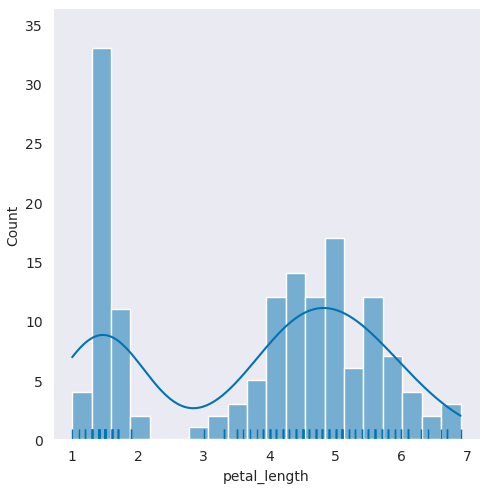

In [18]:
# note - kde, and rug all set to True, set to False to turn them off 
with sns.axes_style("dark"):
    sns.displot(iris['petal_length'], bins=20, 
                kde=True, rug=True)
plt.tight_layout()

The Iris data lives in a 4D space, so plotting more than univariate distributions is important. Fortunately, `seaborn` makes it easy to produce handy summary plots (in a way that is far more comprehensive than `matplotlib`). 

**Problem 2c** 

Make a matplotlib scatter plot showing the Iris petal length against the Iris petal width.

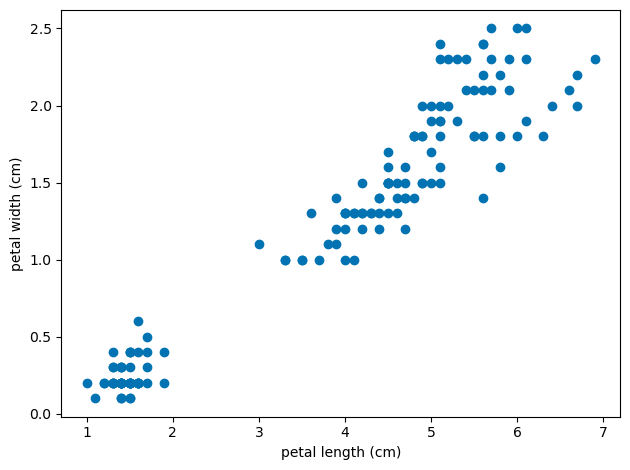

In [19]:
fig, ax = plt.subplots()
ax.scatter(iris["petal_length"], iris["petal_width"])
ax.set_xlabel("petal length (cm)")
ax.set_ylabel("petal width (cm)")
fig.tight_layout()

**Aside**

When there are many many data points, scatter plots become difficult to interpret. 

Execute the cell below:

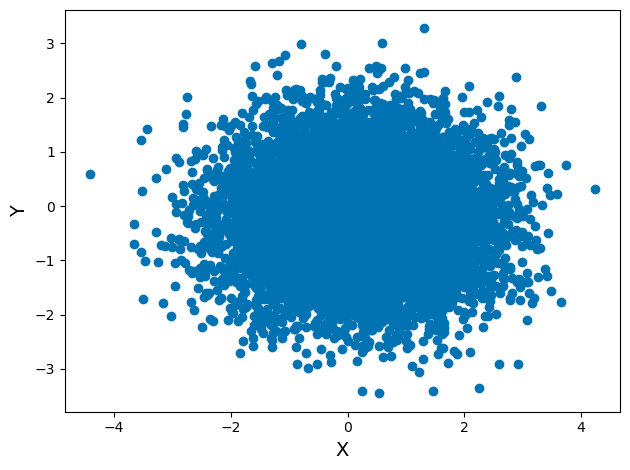

In [20]:
np.random.seed(2016)
xexample = np.random.normal(loc = 0.2, scale = 1.1, size = 10000)
yexample = np.random.normal(loc = -0.2, scale = 0.9, size = 10000)

fig, ax = plt.subplots()
ax.scatter(xexample, yexample)
ax.set_xlabel('X', fontsize=14)
ax.set_ylabel('Y', fontsize=14)
fig.tight_layout()

Here, we see that there are many points, clustered about the origin, but we have no sense of the underlying density of the distribution. 2D histograms, such as `plt.hist2d()`, can alleviate this problem. I prefer to use `plt.hexbin()` which is a little easier on the eyes (though note - these histograms are just as subject to the same issues discussed above). 

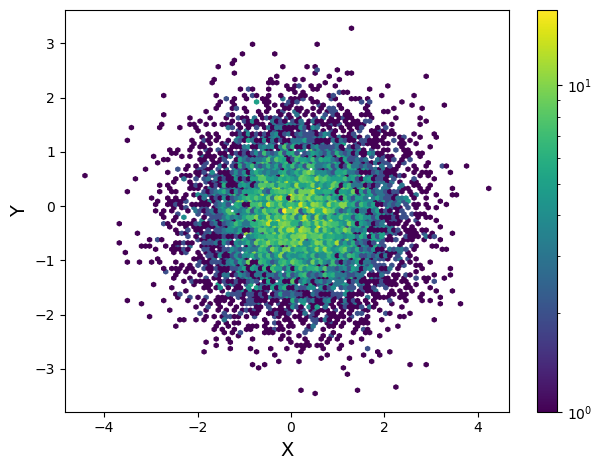

In [21]:
# hexbin w/ bins = "log" returns the log of counts/bin
# mincnt = 1 displays only hexpix with at least 1 source present
fig, ax = plt.subplots()
cax = ax.hexbin(xexample, yexample, bins = "log", cmap = "viridis", mincnt = 1)
ax.set_xlabel('X', fontsize=14)
ax.set_ylabel('Y', fontsize=14)
fig.tight_layout()
plt.colorbar(cax)

While the above plot provides a significant improvement over the scatter plot by providing a better sense of the density near the center of the distribution, the binedge effects are clearly present. Similar to **1g** a density estimate is superior. KDEs are easy in `seaborn` via the `kdeplot` function.

C:\Users\Carlos\AppData\Local\Temp\ipykernel_16620\3949185536.py:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=False`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(x=xexample, y=yexample, shade=False)


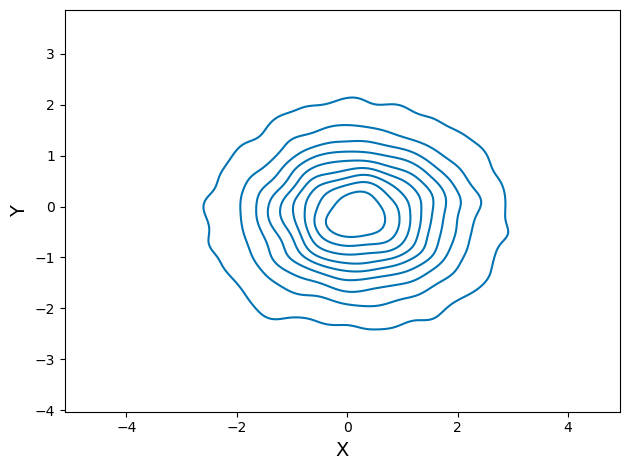

In [22]:
fig, ax = plt.subplots()
sns.kdeplot(x=xexample, y=yexample, shade=False)
ax.set_xlabel('X', fontsize=14)
ax.set_ylabel('Y', fontsize=14)
fig.tight_layout()

This plot is much more appealing (and informative) than the previous two. For the first time we can clearly see that the distribution is not actually centered on the origin. Now we will move back to the Iris data set. 

Suppose we want to see univariate distributions in addition to the scatter plot? This is certainly possible with `matplotlib` and you can find examples on the web, however, with `seaborn` this is really easy.

C:\Users\Carlos\AppData\Local\Temp\ipykernel_16620\2589227462.py:2: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


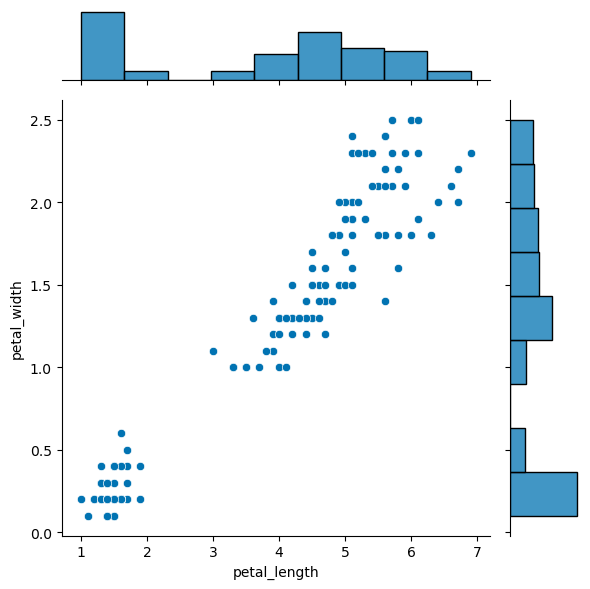

In [23]:
sns.jointplot(x=iris['petal_length'], y=iris['petal_width'])
plt.tight_layout()

But! Histograms and scatter plots can be problematic as we have discussed many times before. 

**Problem 2d** 

Re-create the plot above but set `kind='kde'` to produce density estimates of the distributions.

C:\Users\Carlos\AppData\Local\Temp\ipykernel_16620\4132638415.py:2: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


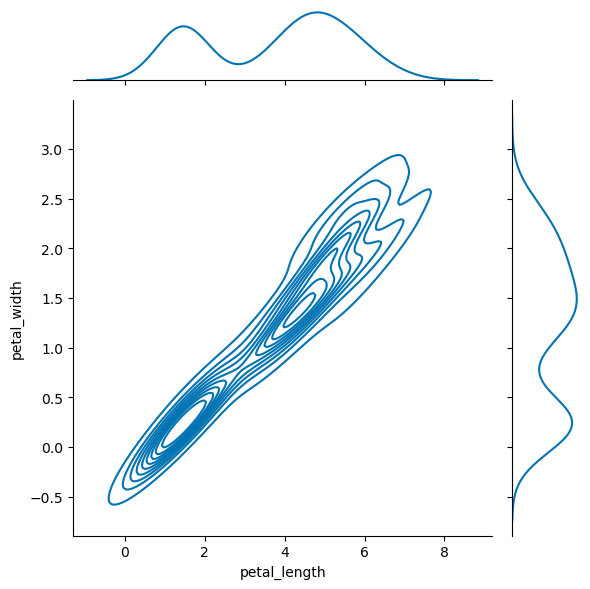

In [24]:
sns.jointplot(x=iris['petal_length'], y=iris['petal_width'], kind='kde')
plt.tight_layout()

That is much nicer than what was presented above. However - we still have a problem in that our data live in 4D, but we are (mostly) limited to 2D projections of that data. One way around this is via the `seaborn` version of a `pairplot`, which plots the distribution of every variable in the data set against each other. (Here is where the integration with `pandas DataFrame`s becomes so powerful.)

c:\Users\Carlos\miniconda3\envs\DSFP\lib\site-packages\seaborn\axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
C:\Users\Carlos\AppData\Local\Temp\ipykernel_16620\3639937624.py:3: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


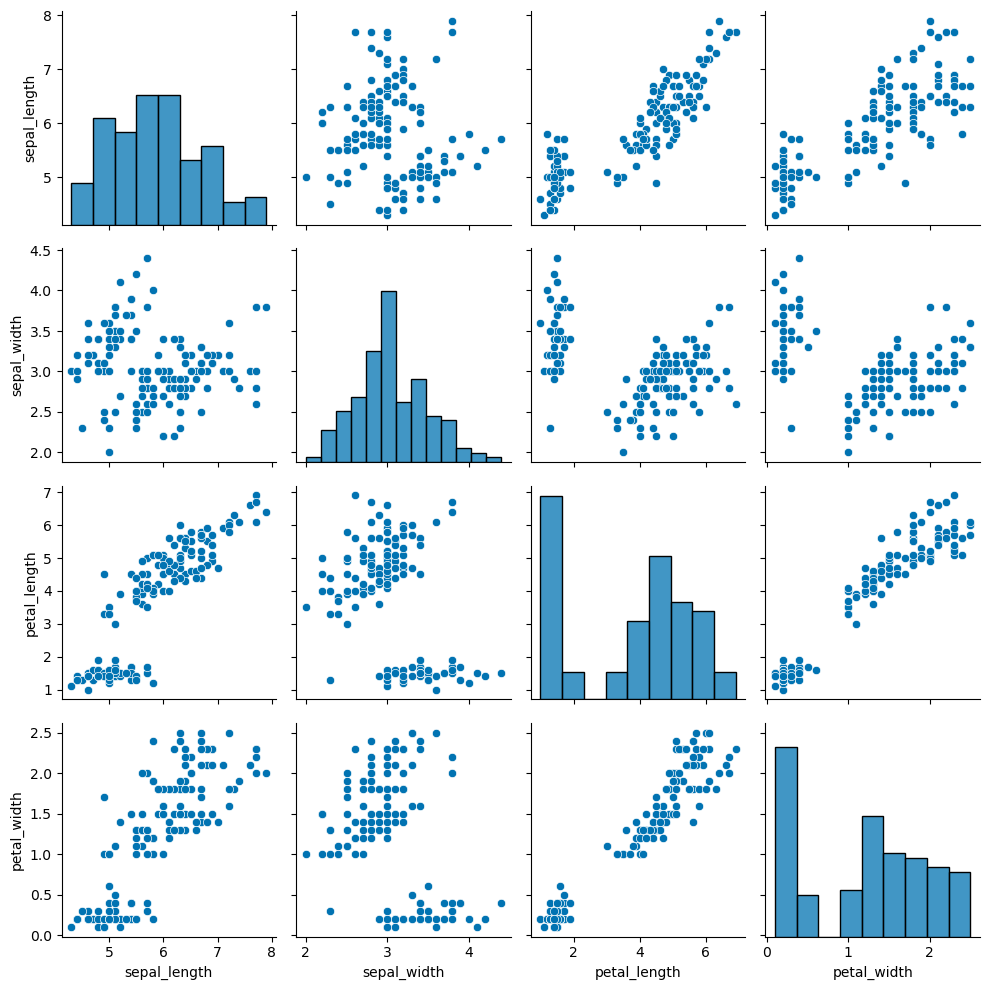

In [25]:
sns.pairplot(iris[["sepal_length", "sepal_width", 
                   "petal_length", "petal_width"]])
plt.tight_layout()

For data sets where we have classification labels, we can even color the various points using the `hue` option, and produce KDEs along the diagonal with `diag_type = 'kde'`.

c:\Users\Carlos\miniconda3\envs\DSFP\lib\site-packages\seaborn\axisgrid.py:123: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


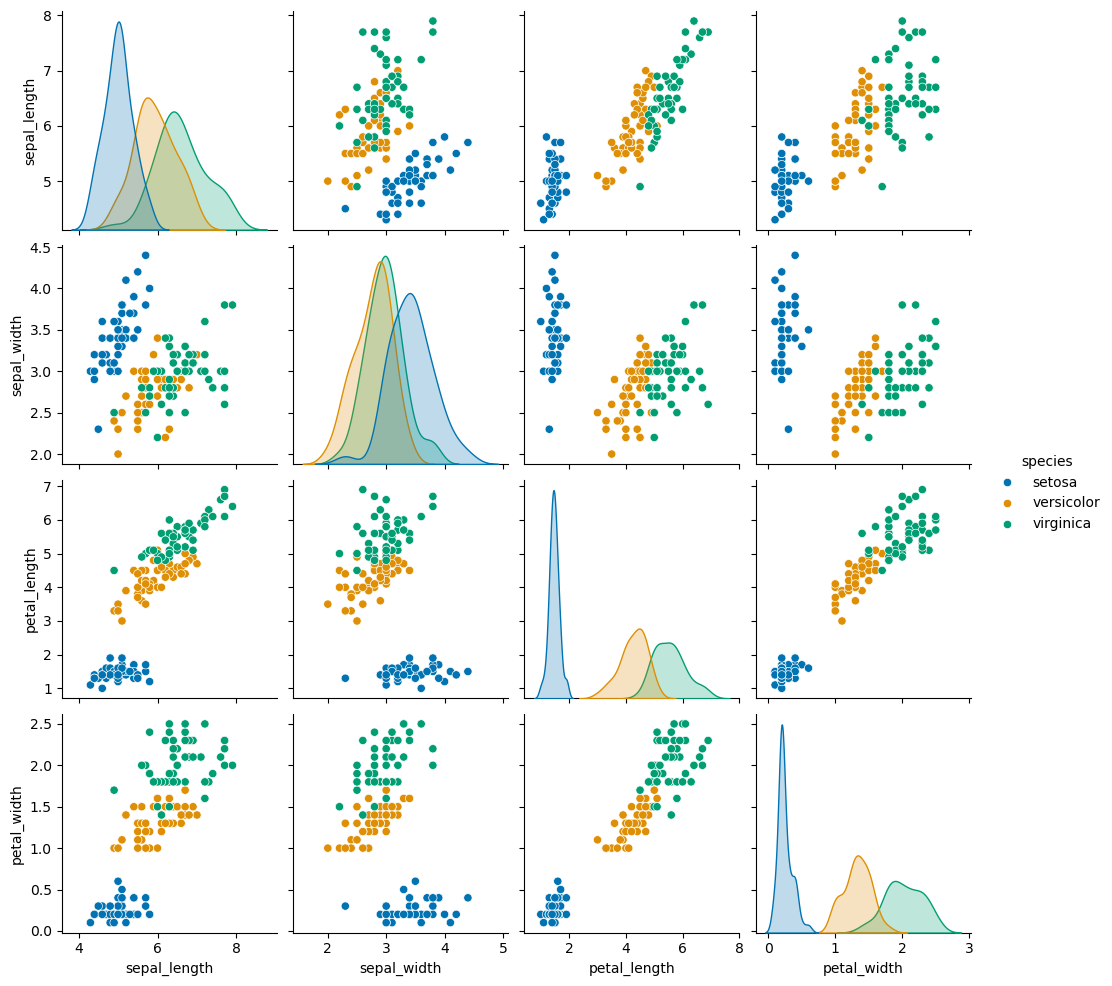

In [26]:
sns.pairplot(iris, vars = ["sepal_length", "sepal_width", "petal_length", "petal_width"],
             hue = "species", diag_kind = 'kde')

Even better - there is an option to create a `PairGrid` which allows fine tuned control of the data as displayed above, below, and along the diagonal. In this way it becomes possible to avoid having symmetric redundancy, which is not all that informative. In the example below, we will show scatter plots and contour plots simultaneously. 

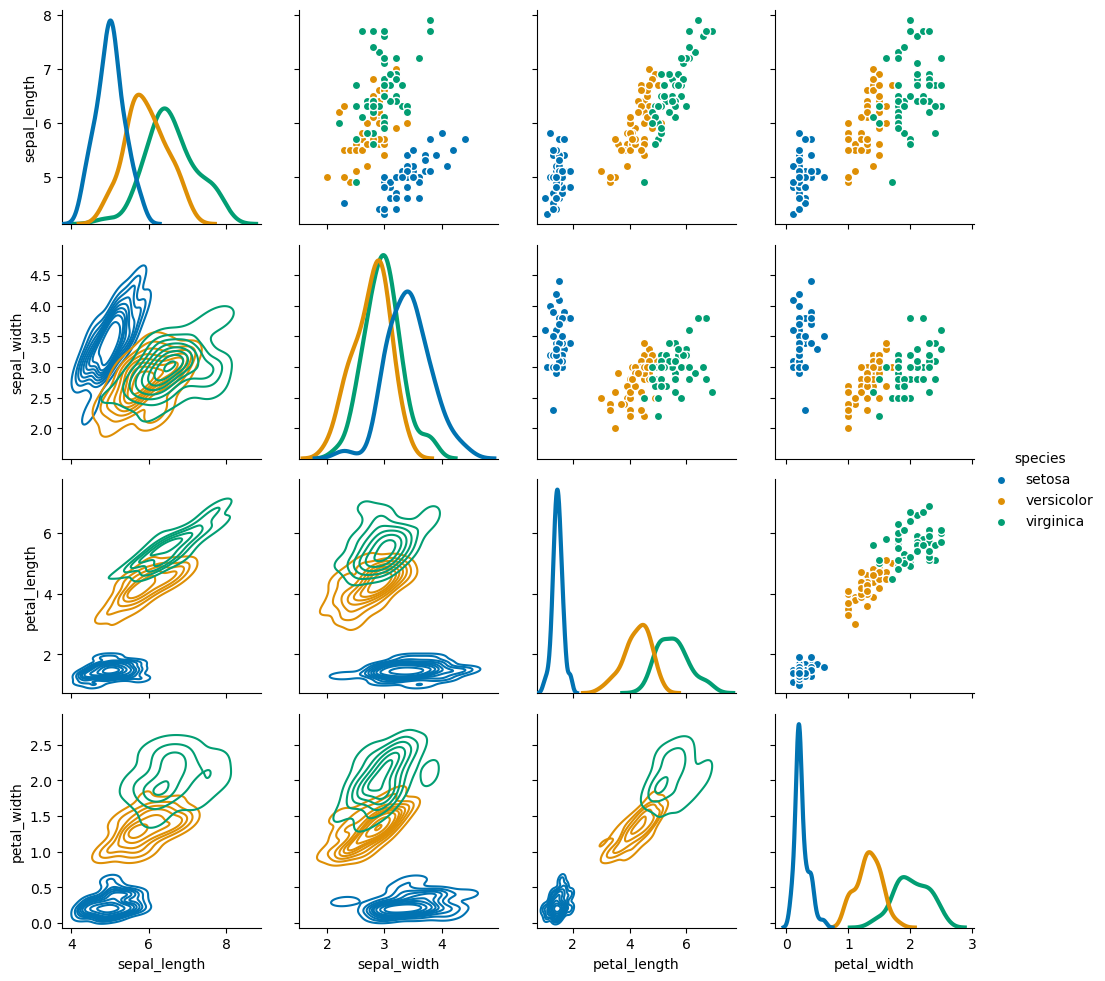

In [27]:
g = sns.PairGrid(iris, vars = ["sepal_length", "sepal_width", "petal_length", "petal_width"],
                 hue = "species", diag_sharey=False)
g.map_lower(sns.kdeplot)
g.map_upper(plt.scatter, edgecolor='white')
g.map_diag(sns.kdeplot, lw=3)
g.add_legend()